This notebook demonstrates the basic training and operation of a bridge network.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
limit_gpus()
set_gpu(0)

In [4]:
dpi = 100

Dataset can be changed to FashionMNIST or others here.

In [5]:
dataset = "mnist"
ds_train, ds_test, ds_info = load_dataset(dataset, 128)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes

Load the pretrained convolutional heads and upscaler.

In [6]:
head = keras.models.load_model("models/ae_conv_head.h5")
inv_head = keras.models.load_model("models/ae_inv_head.h5")

Define the dimensionality of the Bridge network's symbols & the number of hidden neurons in a channel's residual block.

In [7]:
n_d = 1000
n_hidden = 100

image_input = keras.Input(shape=input_shape)
class_input = keras.Input(shape=(n_d,))

In [8]:
bridge = BridgeModel(head, inv_head, ds_info, n_d=n_d, n_hidden=n_hidden, sigma=3.0, overscan=100.0, bind=False)
bridge.compile(optimizer="rmsprop")

In [9]:
bridge.save_weights("models/initvals.k")

Generate from the dataset the symbols which will be used to train the network

In [10]:
data = bridge.generate_external(ds_train, True)

In [11]:
losses = bridge.train(data, epochs=2)

Training loss [0.98406327 0.99522847 1.0021613  0.9978128 ]
Training loss [0.22240789 0.18765995 0.19126563 0.18867114]
Training loss [0.19427684 0.17153406 0.18530303 0.17254338]
Training loss [0.1875229  0.16441369 0.18490791 0.16523032]
Training loss [0.17596465 0.1549478  0.18116313 0.1562976 ]
Training loss [0.17018473 0.15132801 0.18147512 0.15333818]
Training loss [0.17840227 0.15574007 0.18944153 0.15774505]
Training loss [0.1688247  0.14772992 0.18459427 0.14945483]
Training loss [0.16930321 0.14728755 0.1844235  0.14853463]
Training loss [0.16144079 0.14205965 0.18088864 0.14260325]


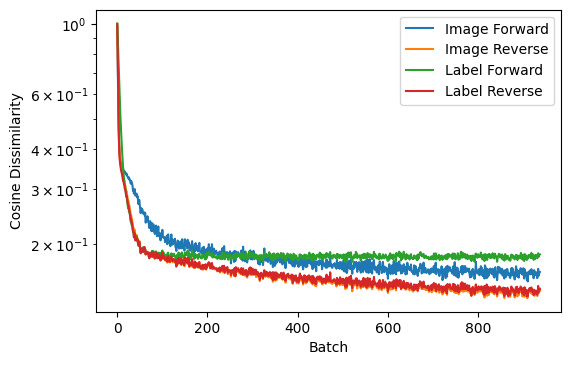

In [12]:
plt.figure(dpi=dpi)
plt.semilogy(losses[:,0], label="Image Forward")
plt.semilogy(losses[:,1], label="Image Reverse")
plt.semilogy(losses[:,2], label="Label Forward")
plt.semilogy(losses[:,3], label="Label Reverse")
plt.xlabel("Batch")
plt.ylabel("Cosine Dissimilarity")
plt.legend()

In [13]:
conf = bridge.accuracy(ds_test, True)

In [14]:
confusion_to_accuracy(conf)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9814>

Text(0, 0.5, 'Guessed Label')

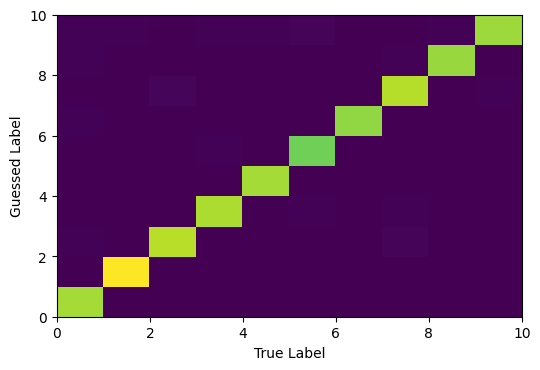

In [15]:
plt.figure(dpi=dpi)
plt.pcolor(conf[0])
plt.xlabel("True Label")
plt.ylabel("Guessed Label")

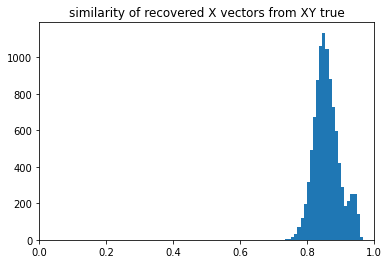

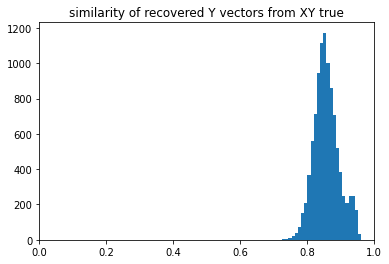

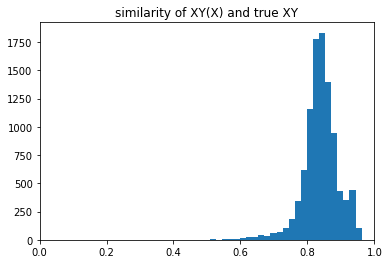

In [16]:
plotinternals(bridge, ds_test)

Create examples of generated images

In [17]:
r_imgs = bridge.reconstruct(data[3][0:32,...])

In [18]:
bridge.label_encoder.noisy = True
bridge.label_encoder.noise = 0.10

In [19]:
all_imgs = []
ns = 5

for i in range(10):
    lbls = bridge.label_encoder(i*tf.ones(ns, dtype=tf.int32))
    syms = bridge.label_ch.forward(lbls)
    syms = bridge.image_ch.reverse(syms)
    feats = bridge.img_encoder.reverse(syms)
    imgs = bridge.inv_head(feats)
    
    all_imgs.append(imgs.numpy())

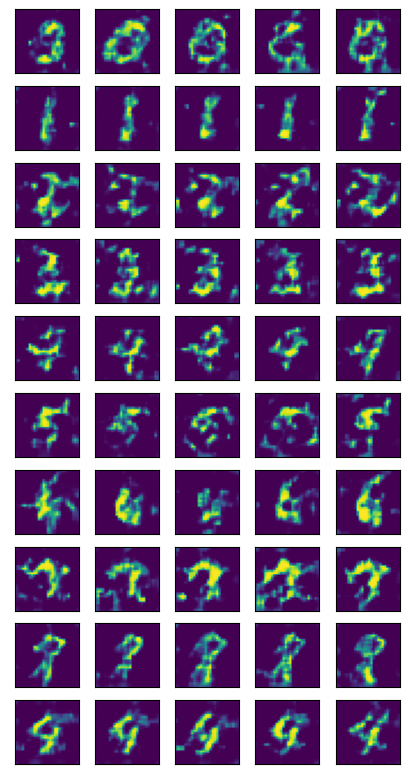

In [20]:
fix, ax = plt.subplots(10, 5, dpi=dpi, figsize=(5,10))

for c in range(10):
    for i in range(5):
        ax[c,i].imshow(all_imgs[c][i,...])
        ax[c,i].get_xaxis().set_visible(False)
        ax[c,i].get_yaxis().set_visible(False)

Self-distill a training set from the model and use it to train a new bridge network with the same initial weights.

In [21]:
r_h0, l_h0 = bridge.reconstruct_info(5000, 400, optimizer=keras.optimizers.RMSprop(lr=0.01))

[1.0013083 1.0010909]
[0.16849662 0.1537102 ]
[0.0934378  0.08209947]
[0.07036079 0.05911497]


Text(0, 0.5, 'Sample Loss')

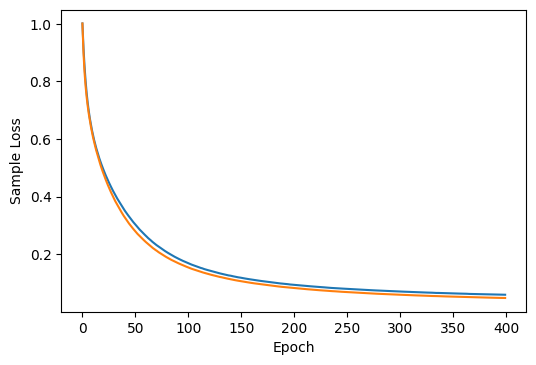

In [36]:
plt.figure(dpi=dpi)
plt.plot(l_h0)
plt.xlabel("Epoch")
plt.ylabel("Sample Loss")

In [23]:
#generate the new model's set of training symbols
ds_h0 = bridge.generate_internal(r_h0, truefwd=False)

In [24]:
bridge_rh0 = BridgeModel(head, inv_head, ds_info, n_d=n_d, n_hidden=n_hidden, sigma=3.0, overscan=100.0, bind=False)
bridge_rh0.compile(optimizer="rmsprop")

In [27]:
bridge_rh0.load_weights("models/initvals.k")

In [29]:
match_normalize(bridge, bridge_rh0)

In [30]:
loss2 = bridge_rh0.train(ds_h0, epochs=10, energy=False)

Training loss [0.94562715 0.95158106 0.9468276  0.97776437]
Training loss [0.29199624 0.24718113 0.09676012 0.13262133]
Training loss [0.20876956 0.15686816 0.03684264 0.07719679]
Training loss [0.14213757 0.11797964 0.0170095  0.04559391]
Training loss [0.10466351 0.09541556 0.01041904 0.03309679]
Training loss [0.08173303 0.0787299  0.00812685 0.02747169]
Training loss [0.06499681 0.0644473  0.00669097 0.02388772]
Training loss [0.05156533 0.05238321 0.00588678 0.02162005]
Training loss [0.04145441 0.04282206 0.00521087 0.01978999]
Training loss [0.03464591 0.03564861 0.00487135 0.01792627]


Text(0, 0.5, 'Cosine Similarity')

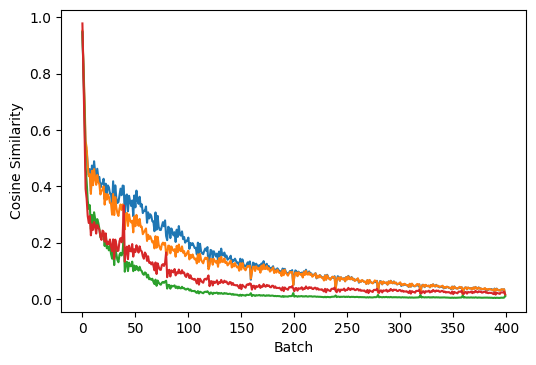

In [41]:
plt.figure(dpi=dpi)
plt.plot(loss2)
plt.xlabel("Batch")
plt.ylabel("Cosine Similarity")

In [37]:
conf_r = bridge_rh0.accuracy(ds_test, True, False)

Text(0, 0.5, 'Guessed Label')

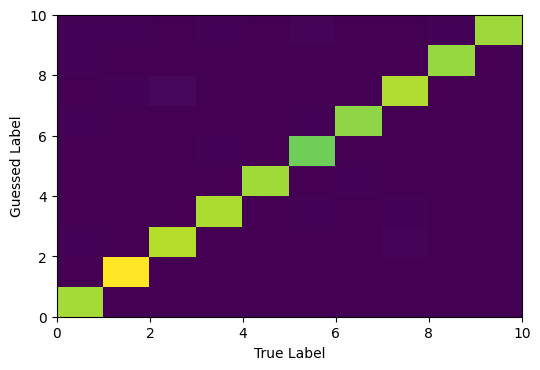

In [40]:
plt.figure(dpi=dpi)
plt.pcolor(conf_r[0])
plt.xlabel("True Label")
plt.ylabel("Guessed Label")

In [39]:
confusion_to_acc(conf_r[0])

0.979